In [108]:
##################################### HELPER FUNCTIONS AND CONFIGURATIONS #########################################
import seaborn as sns # for data visualization
from matplotlib.collections import PathCollection
import os
import pprint
import random
import statistics
import scipy.stats
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = [15, 10]
import json
import pandas as pd
import glob
import math
import ast
%matplotlib inline

pp       =  pprint.PrettyPrinter(compact=True)

LOGFILES =  glob.glob('logs/randomtests/*.json' )

print(len(LOGFILES),"logs")

#=== line colors and styles

linestyles = {
    #=======floorplans===============
    'office'              : 'dotted' ,
    'warehouse'           : 'dashed' ,
    'factory'             : 'dashdot',
    "scattered_obstacles" : 'dotted',
    #=======algorithms================
    #------exploration---------------- 
    'Atlas'      :    'solid',
    #----relay placement--------------
    'Recovery'   :    'dotted',
    'SelfHealing':    'dashed',
    #---- number of robots------------
    '15'         :    'dotted',
    '25'         :    'dashed',
    '50'         :    'dashdot',
}

linecolors = {
    #=======floorplans==============
    'office'              : 'orange',
    'warehouse'           : 'green',
    'factory'             : 'purple',
    "scattered_obstacles" : 'blue',
    #=======algorithms==============
    #------exploration--------------
    'Atlas'      :  'royalblue',
    #------relay placement----------
    'Recovery'   :     'purple',
    'SelfHealing':     'green',
    'Naive'      :     'orange',
     #---- number of robots------------
    (15, 'Recovery')    :    'orchid',
    (15, 'SelfHealing') :    'mediumseagreen',
    (25, 'Recovery')    :    'darkmagenta',
    (25, 'SelfHealing') :    'olivedrab',
    (50, 'Recovery')    :    'magenta',
    (50, 'SelfHealing') :    'forestgreen',

   }

#=== helper functions

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return (m, h)

def mode_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = scipy.stats.mode(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return (m[0][0], h)

1440 logs


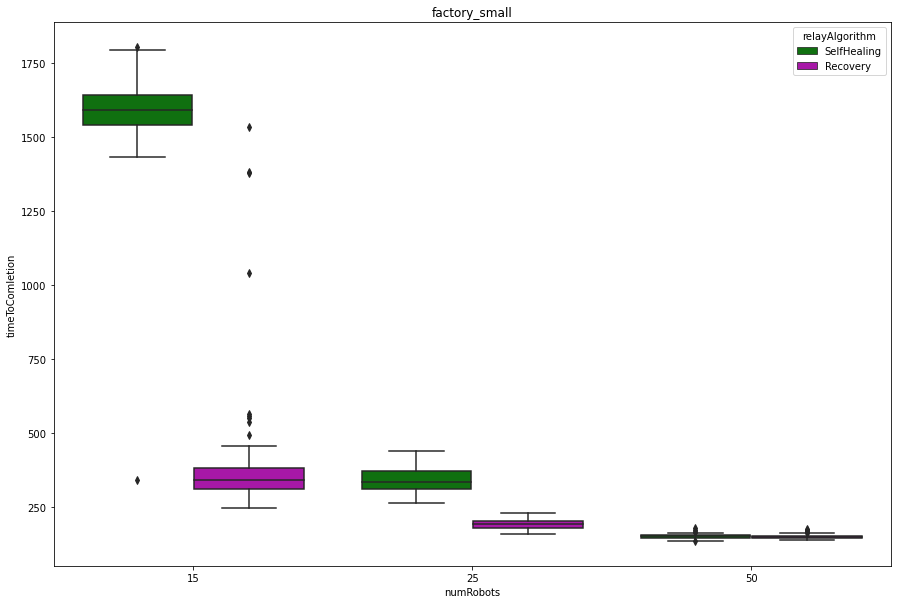

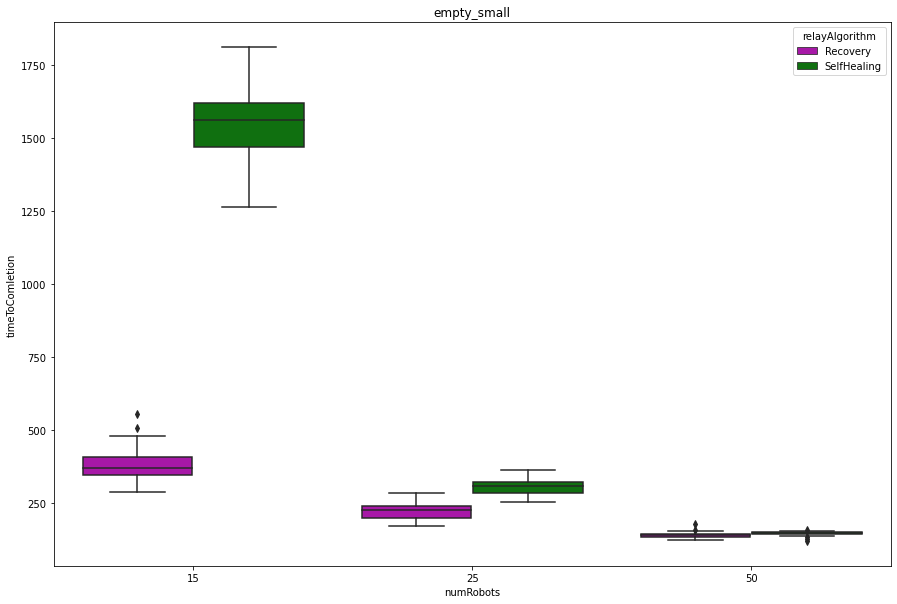

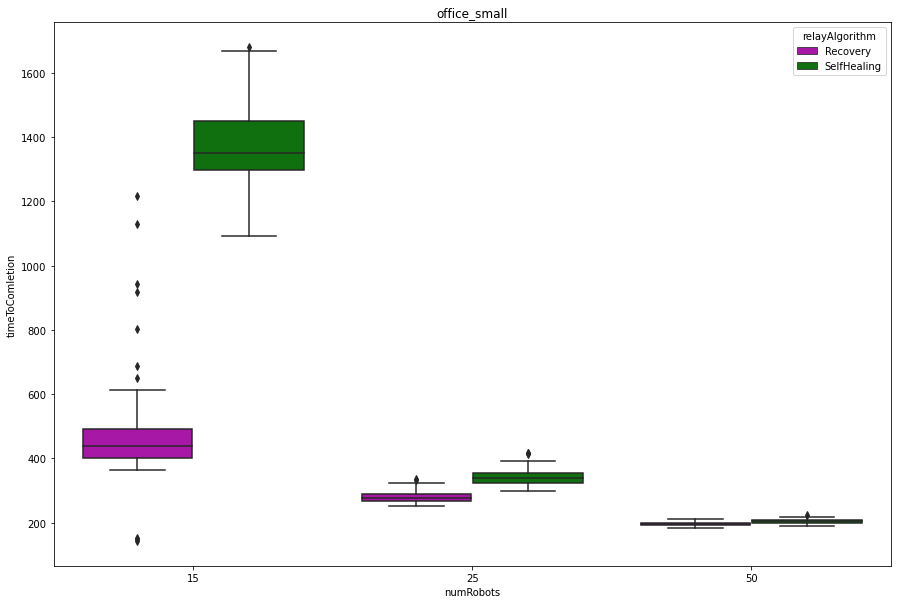

In [109]:

#============ Time To Completion
plt.rcParams['pdf.fonttype']   = 42
plt.rcParams['ps.fonttype']    = 42
plt.rcParams['figure.figsize'] = [15, 10]

# format -> data = {seed1: {config: {....}}, timeToCompletion: 2142}, seed2: {...} , ...}
data      =  []
for file in LOGFILES:
  FILENAME = file
  # gather
  with open(FILENAME,'r') as f:
    lines  = [json.loads(l) for l in f]
    for line in lines:
        if line["type"] == "simSetting":
            numRobots             = line['simSetting']['numRobots'] 
            floorplan             = line['simSetting']['floorplan'] 
            relayAlgorithm        = line['simSetting']['relayAlgorithm']
            
        
        if ((line["type"] == "KPI") and ('timeToCompletion' in line.keys())):
            if line['timeToCompletion'] != None:
                timeToCompletion      = line['timeToCompletion']
                break
 
    data += [
        {"numRobots":       numRobots,
         "floorplan":       floorplan,
         "relayAlgorithm":  relayAlgorithm,
         "timeToComletion": timeToCompletion,
        }
    ]

floorplans      = list(set([d['floorplan'] for d in data]))
relayAlgorithms = list(set([d['relayAlgorithm'] for d in data]))
numRobots       = list(set([d['numRobots'] for d in data]))
numRobots.sort()
my_palette      = {"Recovery": "m", "SelfHealing": "g"} 
for floorplan in floorplans:
    (fig,ax) = plt.subplots()
    
    df  = pd.DataFrame([d for d in data if d['floorplan'] == floorplan])
    sns.boxplot(
        x="numRobots", y="timeToComletion", hue ="relayAlgorithm", palette=my_palette, data=df
    ).set_title(floorplan)





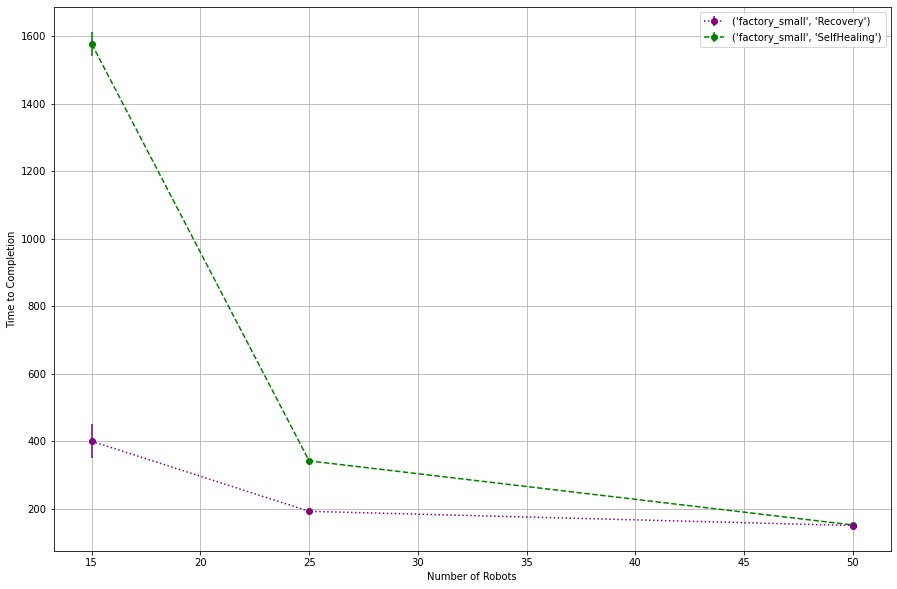

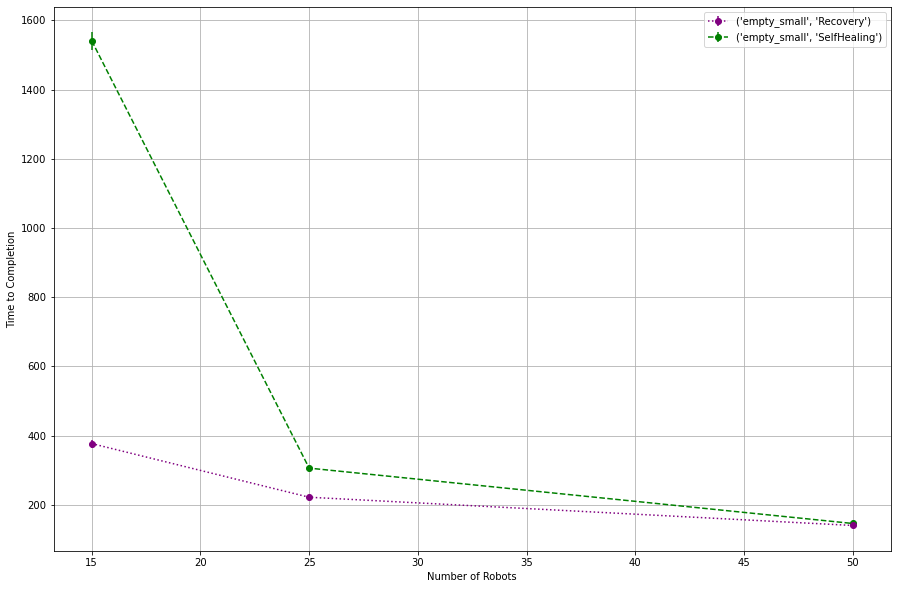

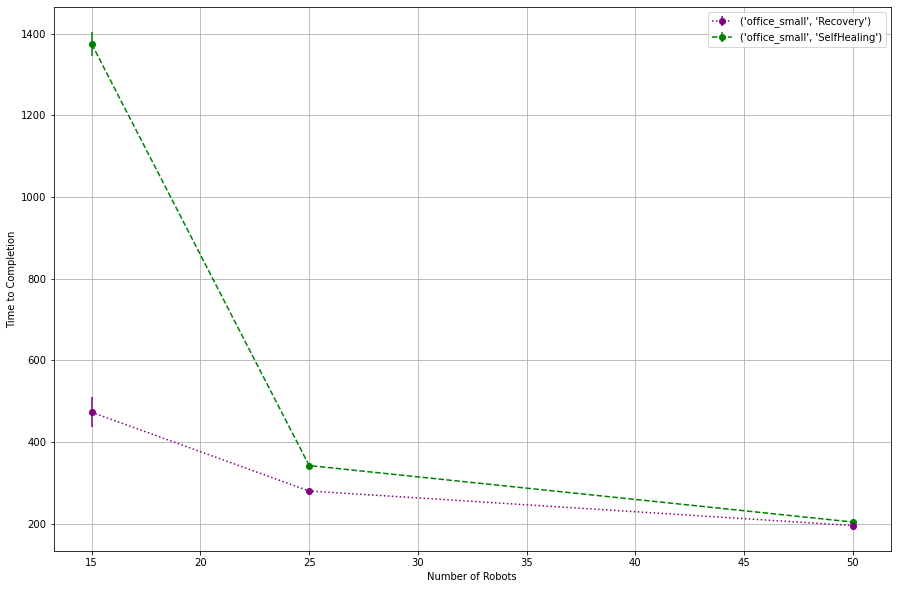

In [110]:

#============ Time To Completion
plt.rcParams['pdf.fonttype']   = 42
plt.rcParams['ps.fonttype']    = 42
plt.rcParams['figure.figsize'] = [15, 10]

# format -> data = {seed1: {config: {....}}, timeToCompletion: 2142}, seed2: {...} , ...}
data      =  []
for file in LOGFILES:
  FILENAME = file
  # gather
  with open(FILENAME,'r') as f:
    lines  = [json.loads(l) for l in f]
    for line in lines:
        if line["type"] == "simSetting":
            numRobots             = line['simSetting']['numRobots'] 
            floorplan             = line['simSetting']['floorplan'] 
            relayAlgorithm        = line['simSetting']['relayAlgorithm']
            
        
        if ((line["type"] == "KPI") and ('timeToCompletion' in line.keys())):
            if line['timeToCompletion'] != None:
                timeToCompletion      = line['timeToCompletion']
                break
 
    data += [
        {"numRobots":       numRobots,
         "floorplan":       floorplan,
         "relayAlgorithm":  relayAlgorithm,
         "timeToComletion": timeToCompletion,
        }
    ]

floorplans      = list(set([d['floorplan'] for d in data]))
relayAlgorithms = list(set([d['relayAlgorithm'] for d in data]))
numRobots       = list(set([d['numRobots'] for d in data]))
numRobots.sort()

for floorplan in floorplans:
    (fig,ax) = plt.subplots()
    lines    = {}

    for relayAlgorithm in relayAlgorithms:
        toPlot = {}
        x      = []
        y      = []
        yerr   = []
        
        for value in numRobots:
            toPlot[value] = {}
            (m, h) = mean_confidence_interval(
                [
                 d["timeToComletion"] for d in data       if 
                 d['numRobots']      == value             and 
                 d['floorplan']      == floorplan         and 
                 d['relayAlgorithm'] == relayAlgorithm
                ]
            )
            toPlot[value]["mean"] = m
            toPlot[value]["yerr"] = h
        x                = numRobots
        y                = [p["mean"] for p in toPlot.values()]
        yerr             = [p["yerr"] for p in toPlot.values()]
        lines[(floorplan, relayAlgorithm)] = ax.errorbar(x, y, yerr=yerr,linestyle=linestyles[relayAlgorithm],color=linecolors[relayAlgorithm],label=(floorplan, relayAlgorithm), marker='o')
           
    ax.grid(True, zorder=5)
    plt.xlabel("Number of Robots")
    plt.ylabel("Time to Completion")
    plt.legend(handles=[lines[(floorplan,'Recovery')], lines[(floorplan, 'SelfHealing')]])
    plt.show()


No handles with labels found to put in legend.


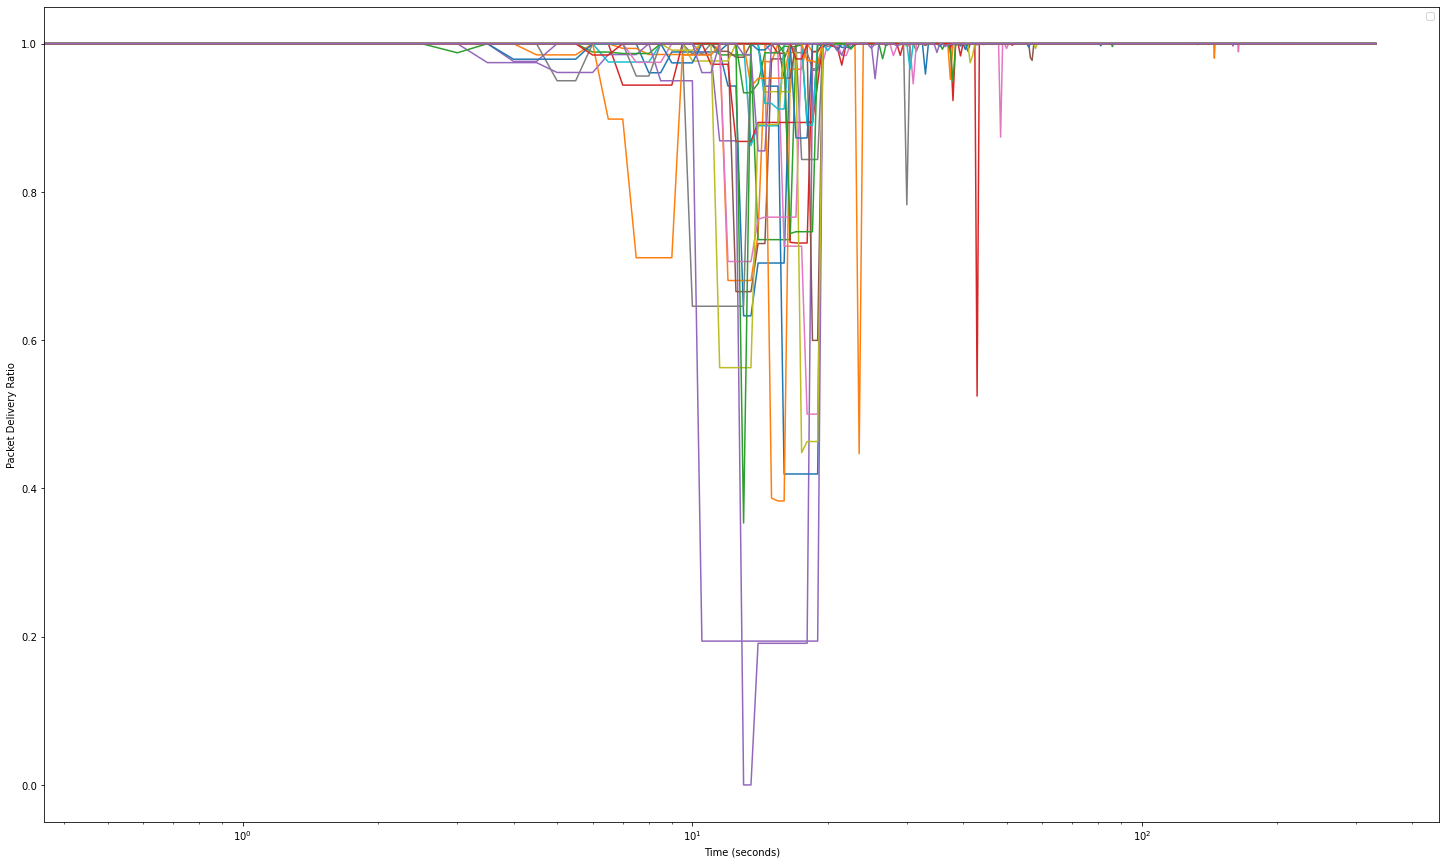

In [111]:
#============ Plot Average PDR Vs. Time
import math

plt.rcParams['pdf.fonttype']   = 42
plt.rcParams['ps.fonttype']    = 42
plt.rcParams['figure.figsize'] = [25, 15]

# format -> data = {seed1: {config: {....}}, PDRs: [[1,1,1,1], [1,1,1,1], ...], numOfRelays: [0, 1,2, ..]},
#                   seed2: {...} , ...}
data       =  []
for file in LOGFILES:
  FILENAME = file
  # gather
  with open(FILENAME,'r') as f:
    lines       = [json.loads(l) for l in f]
    PDRs        = []
    numOfRelays = []
    time        = []
    for line in lines:
        if line["type"] == "simSetting":
            numRobots       = line['simSetting']['numRobots'] 
            floorplan       = line['simSetting']['floorplan'] 
            relayAlgorithm  = line['simSetting']['relayAlgorithm']
            
        
        if ((line["type"] == "KPI") and ('PDRs' in line.keys())) :
            PDRs         += [line['PDRs']]
            numOfRelays  += [line['numOfRelays']]
            time         += [line['time']]
 
    data += [
        {"numRobots":       numRobots,
         "floorplan":       floorplan,
         "relayAlgorithm":  relayAlgorithm,
         "PDRs":            PDRs,
         "numOfRelays":     numOfRelays,
         "time":            time,
        }
    ]

floorplans      = list(set([d['floorplan'] for d in data]))
relayAlgorithms = list(set([d['relayAlgorithm'] for d in data]))
numRobots       = list(set([d['numRobots'] for d in data]))

numRobots.sort()
(fig,ax) = plt.subplots()
lines    = {}
for i in range(len(data[0]["PDRs"][0])):    
    pdrsPerDotBot = [d[i] for d in data[0]["PDRs"]]
    y             = pdrsPerDotBot
    x             = data[0]["time"]
    lines[i]      = ax.plot(x,y)

#convert x-axis to Logarithmic scale
plt.xscale("log")
plt.xlabel("Time (seconds)")
plt.ylabel("Packet Delivery Ratio")
plt.legend()
alllines = lines
plt.show()
    
            

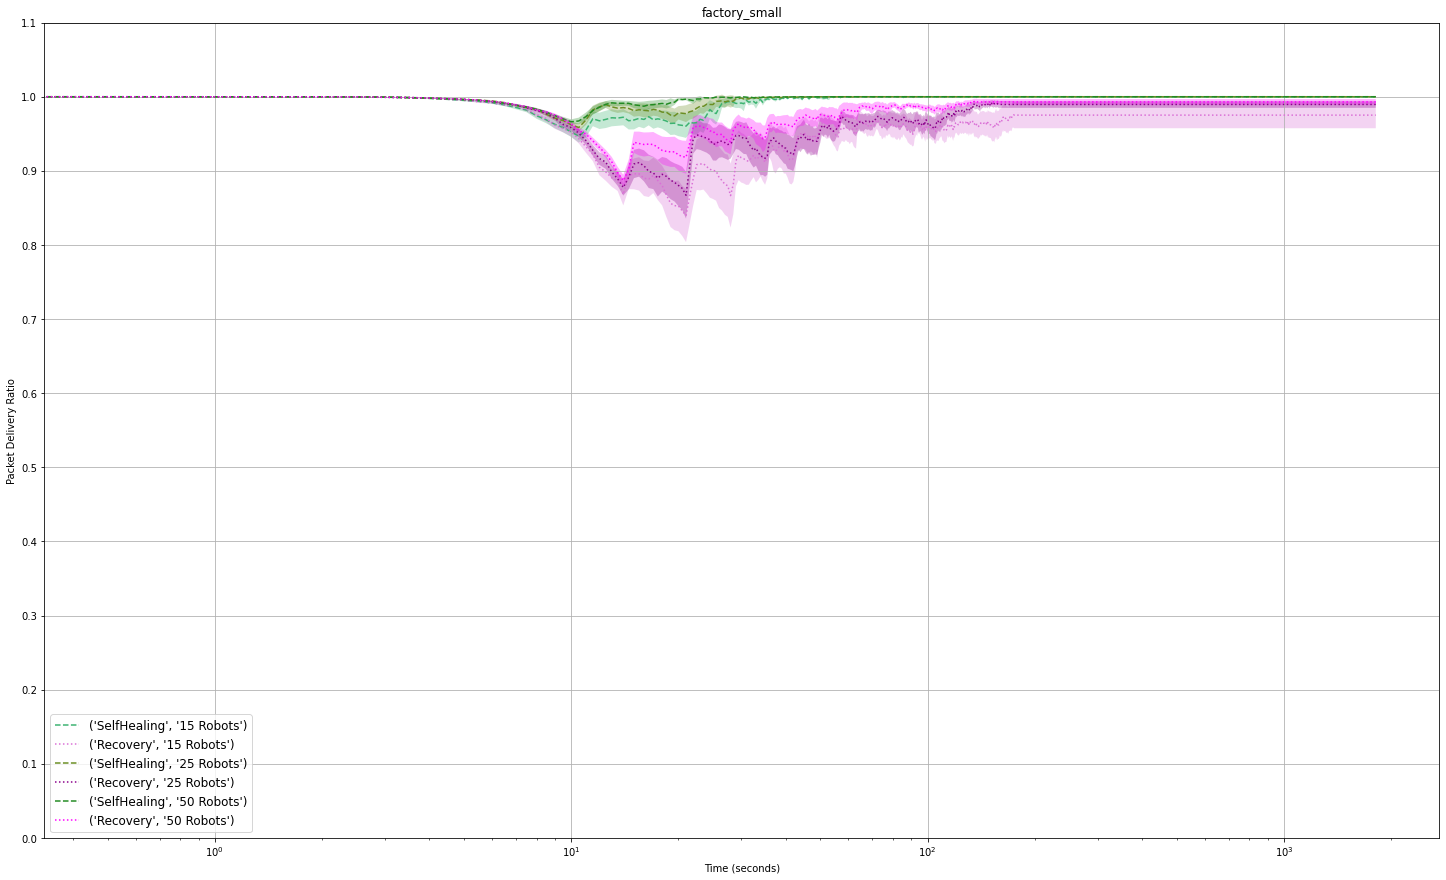

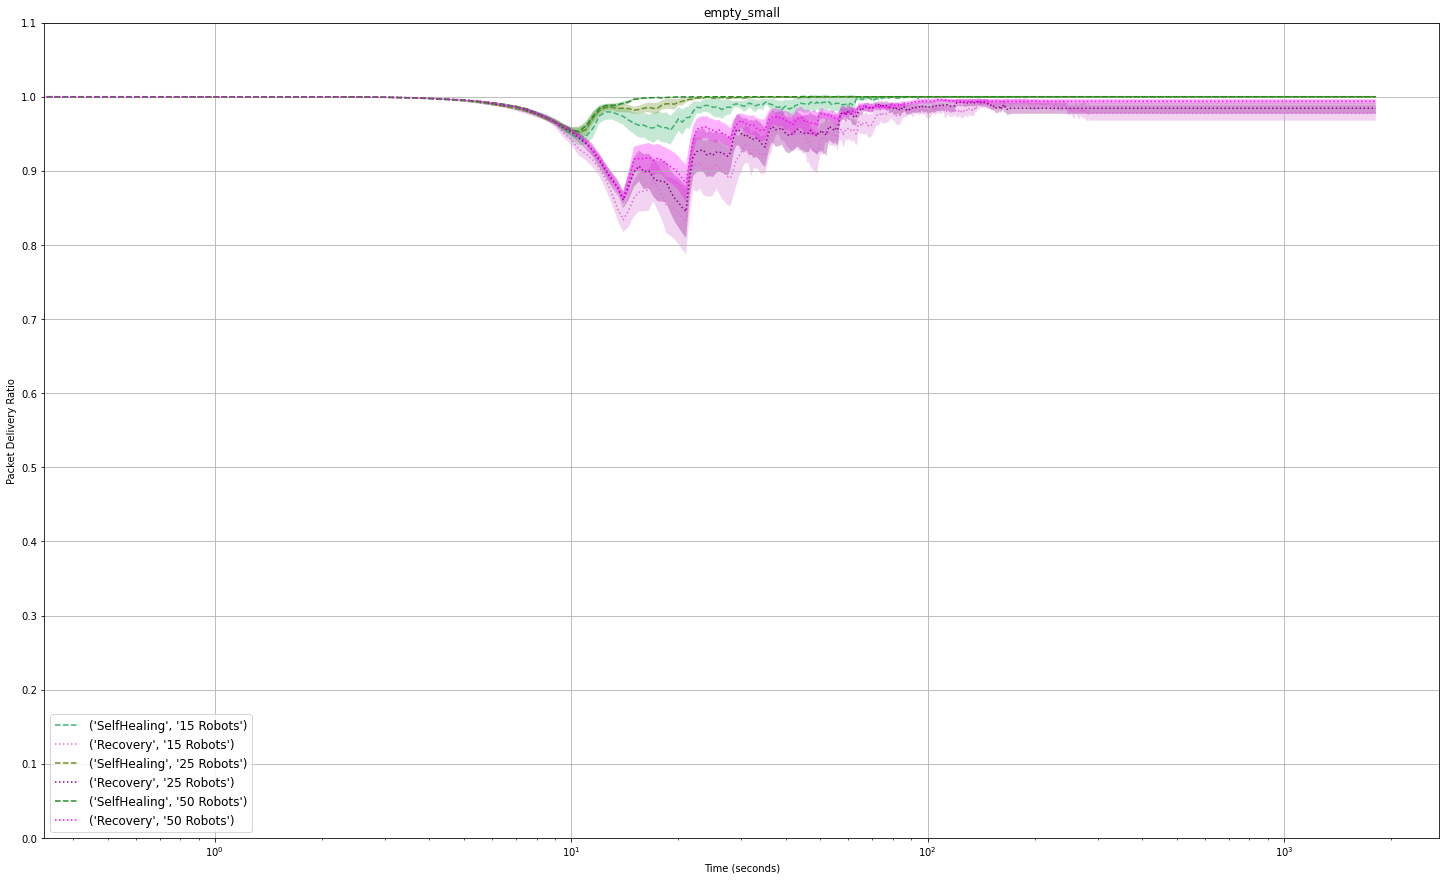

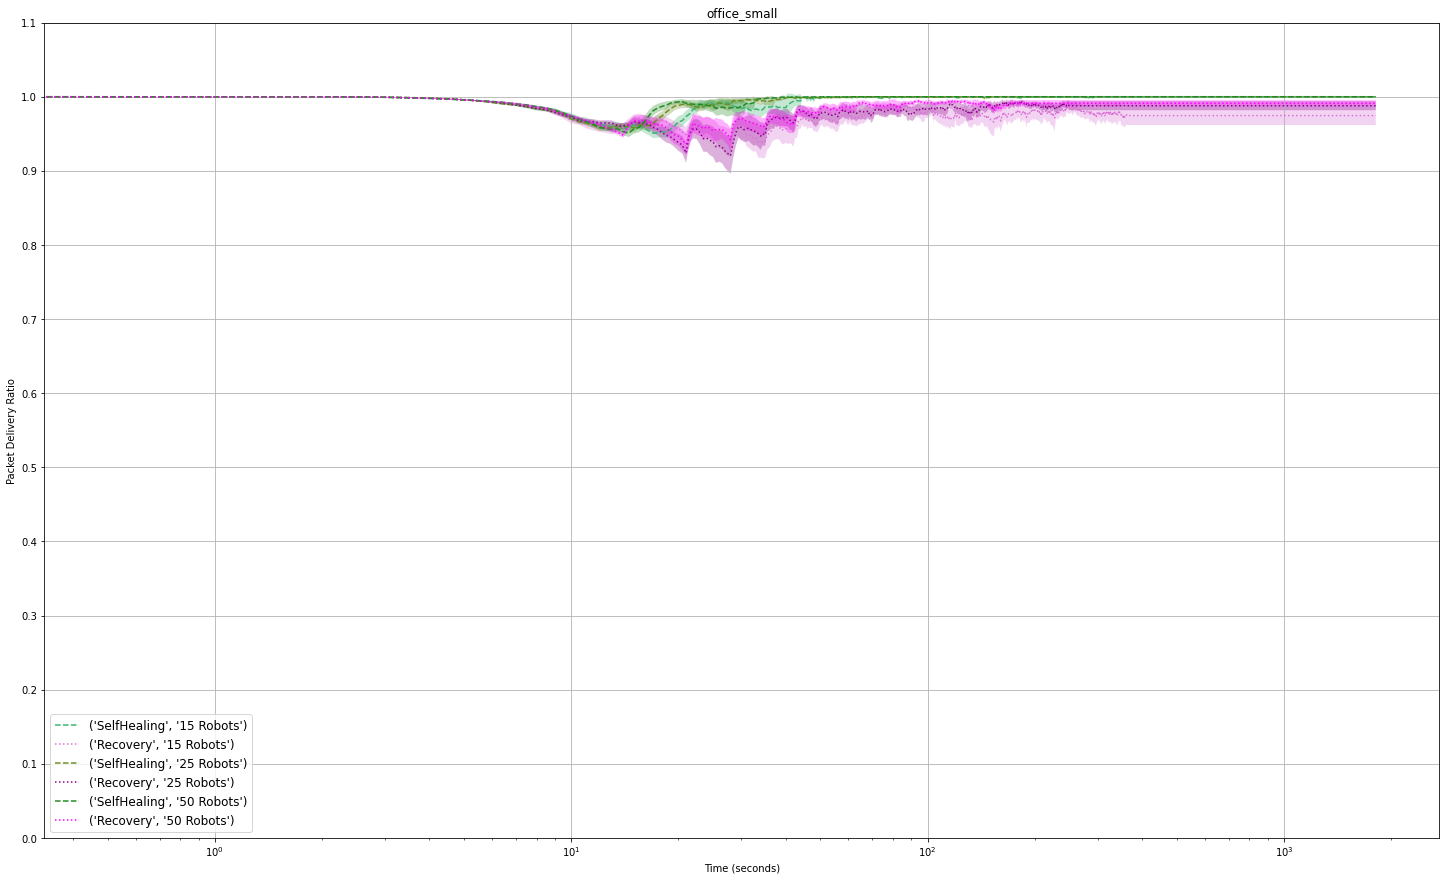

In [112]:
#============ Plot Average PDR Vs. Time
import math

plt.rcParams['pdf.fonttype']   = 42
plt.rcParams['ps.fonttype']    = 42
plt.rcParams['figure.figsize'] = [25, 15]

# format -> data = {seed1: {config: {....}}, PDRs: [[1,1,1,1], [1,1,1,1], ...], numOfRelays: [0, 1,2, ..]},
#                   seed2: {...} , ...}
data      =  []
for file in LOGFILES:
  FILENAME = file
  # gather
  with open(FILENAME,'r') as f:
    lines       = [json.loads(l) for l in f]
    PDRs        = []
    numOfRelays = []
    time        = []
    for line in lines:
        if line["type"] == "simSetting":
            numRobots       = line['simSetting']['numRobots'] 
            floorplan       = line['simSetting']['floorplan'] 
            relayAlgorithm  = line['simSetting']['relayAlgorithm']
            
        
        if ((line["type"] == "KPI") and ('PDRs' in line.keys())) :
            PDRs         += [sum(line['PDRs'])/len(line['PDRs'])]
            numOfRelays  += [line['numOfRelays']]
            time         += [line['time']]
 
    data += [
        {"numRobots":       numRobots,
         "floorplan":       floorplan,
         "relayAlgorithm":  relayAlgorithm,
         "PDRs":            PDRs,
         "numOfRelays":     numOfRelays,
         "time":            time,
        }
    ]

floorplans      = list(set([d['floorplan'] for d in data]))
relayAlgorithms = list(set([d['relayAlgorithm'] for d in data]))
numRobots       = list(set([d['numRobots'] for d in data]))
numRobots.sort()
timelines       = [d['time'] for d in data]        
maxtime         = max([t[-1] for t in timelines])

for floorplan in floorplans:
    (fig,ax)   = plt.subplots()
    lines      = {}
    linesfill  = {}
    for value in numRobots:
        toPlot = {}
        for relayAlgorithm in relayAlgorithms:
            toPlot[value] = {"mean": [], "yerr": [], "y1err": [], "y2err": []}
            for i in range(max([len(d['PDRs']) for d in data])):
                try:
                    (m, h) = mean_confidence_interval(
                        [
                         d["PDRs"][i] for d in data            if 
                         d['numRobots']      == value          and 
                         d['floorplan']      == floorplan      and 
                         d['relayAlgorithm'] == relayAlgorithm
                        ]
                    )
                except:
                    pass

                toPlot[value]["mean"]    += [m]
                toPlot[value]["yerr"]    += [h]
                toPlot[value]["y1err"]   += [m-h]
                toPlot[value]["y2err"]   += [m+h]
            x                             = np.arange(0, maxtime+0.5, 0.5)
            y                             = toPlot[value]["mean"]
            yerr                          = toPlot[value]["yerr"]
            lines[(floorplan, value)]     = ax.errorbar(x, y, ecolor="gainsboro", linestyle=linestyles[relayAlgorithm],color=linecolors[(value, relayAlgorithm)],label=(relayAlgorithm, str(value)+" Robots"))
            linesfill[(floorplan, value)] = ax.fill_between(x, toPlot[value]["y1err"], toPlot[value]["y2err"] ,alpha=0.3, facecolor=linecolors[(value, relayAlgorithm)])
    
    #convert x-axis to Logarithmic scale
    ax.grid(True)
    plt.title(floorplan)
    plt.xscale("log")
    plt.xlabel("Time (seconds)")
    ax.set_yticks(np.arange(0, 1.2, 0.1))
    plt.ylabel("Packet Delivery Ratio")
    plt.legend(fontsize='large', fancybox=True)
    alllines     = lines
    alllinesfill = linesfill
    plt.show()
    
            


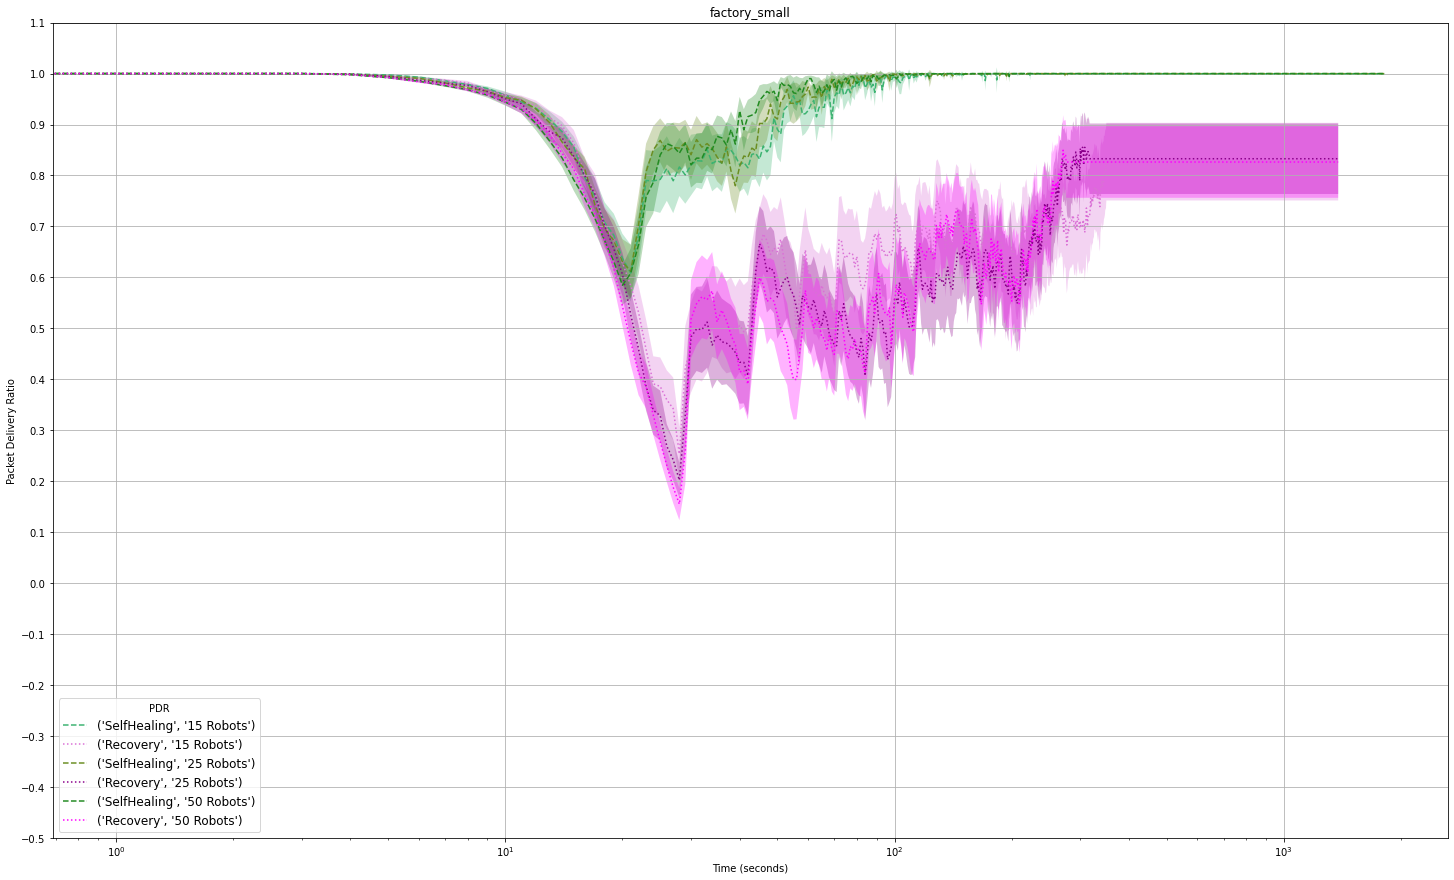

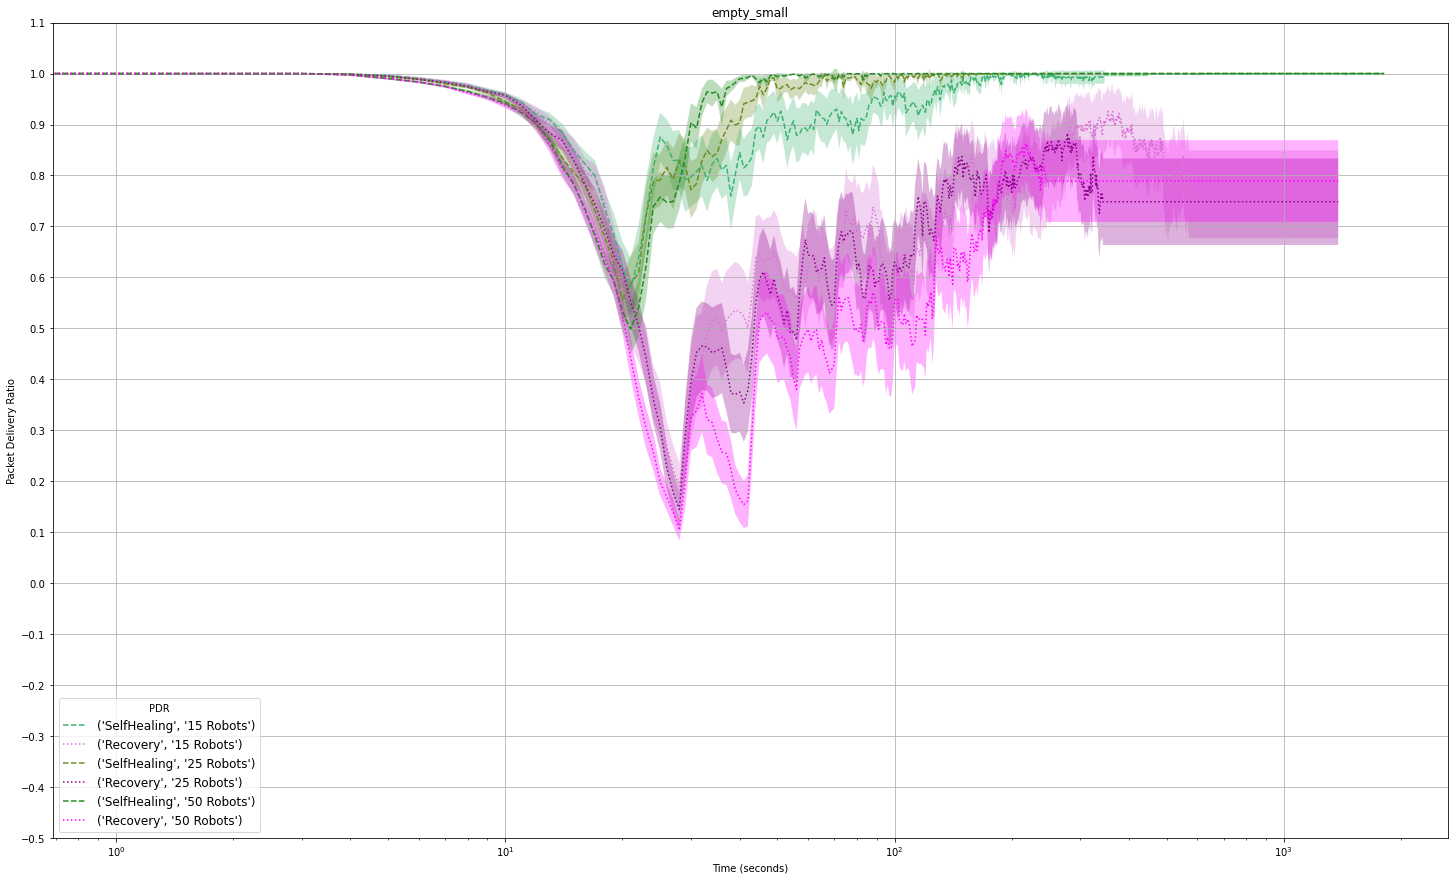

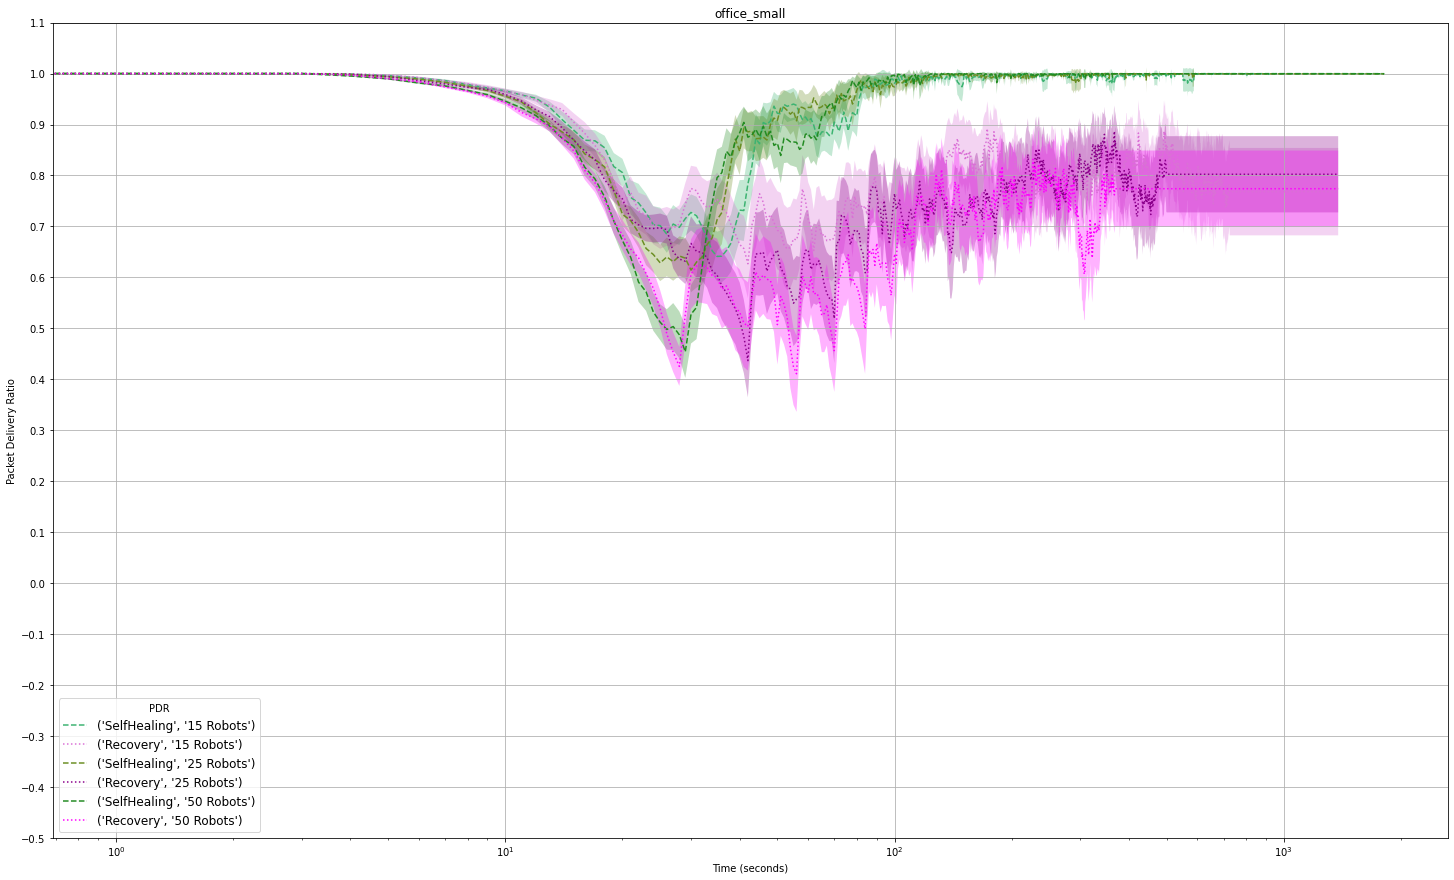

In [113]:
#============ Plot minimum PDR Vs. Time
import math

plt.rcParams['pdf.fonttype']   = 42
plt.rcParams['ps.fonttype']    = 42
plt.rcParams['figure.figsize'] = [25, 15]

# format -> data = {seed1: {config: {....}}, PDRs: [[1,1,1,1], [1,1,1,1], ...], numOfRelays: [0, 1,2, ..]},
#                   seed2: {...} , ...}
data      =  []
for file in LOGFILES:
  FILENAME = file
  # gather
  with open(FILENAME,'r') as f:
    lines       = [json.loads(l) for l in f]
    PDRs        = []
    numOfRelays = []
    time        = []
    for line in lines:
        if line["type"] == "simSetting":
            numRobots       = line['simSetting']['numRobots'] 
            floorplan       = line['simSetting']['floorplan'] 
            relayAlgorithm  = line['simSetting']['relayAlgorithm']
            
        
        if ((line["type"] == "KPI") and ('PDRs' in line.keys())):
            PDRs         += [min(line['PDRs'])]
            numOfRelays  += [line['numOfRelays']]
            time         += [line['time']]
 
    data += [
        {"numRobots":       numRobots,
         "floorplan":       floorplan,
         "relayAlgorithm":  relayAlgorithm,
         "PDRs":            PDRs,
         "numOfRelays":     numOfRelays,
         "time":            time,
        }
    ]

floorplans      = list(set([d['floorplan'] for d in data]))
relayAlgorithms = list(set([d['relayAlgorithm'] for d in data]))
numRobots       = list(set([d['numRobots'] for d in data]))
numRobots.sort()

for floorplan in floorplans:
    (fig,ax)    = plt.subplots()
    lines       = {}
    linesfill   = {}
    for value in numRobots:
        toPlot = {}
        for relayAlgorithm in relayAlgorithms:
            toPlot[value]   = {"mean": [], "yerr": [], "y1err": [], "y2err": []}
            timelines       = [d['time'] for d in data if d['relayAlgorithm']==relayAlgorithm]        
            maxtime         = max([t[-1] for t in timelines])
            
            for i in range(int(maxtime)):
                try:
                    (m, h) = mean_confidence_interval(
                        [
                         d["PDRs"][i] for d in data            if 
                         d['numRobots']      == value          and 
                         d['floorplan']      == floorplan      and 
                         d['relayAlgorithm'] == relayAlgorithm
                        ]
                    )
                except:
                    pass

                toPlot[value]["mean"]    += [m]
                toPlot[value]["yerr"]    += [h]
                toPlot[value]["y1err"]   += [m-h]
                toPlot[value]["y2err"]   += [m+h]
            y                             = toPlot[value]["mean"]
            x                             = np.arange(0, len(y))
            yerr                          = toPlot[value]["yerr"]
            lines[(floorplan, value)]     = ax.errorbar(x, y, ecolor="gainsboro", linestyle=linestyles[relayAlgorithm],color=linecolors[(value, relayAlgorithm)],label=(relayAlgorithm, str(value)+" Robots"))
            linesfill[(floorplan, value)] = ax.fill_between(x, toPlot[value]["y1err"], toPlot[value]["y2err"] ,alpha=0.3, facecolor=linecolors[(value, relayAlgorithm)])
    
    #convert x-axis to Logarithmic scale
    ax.grid(True)
    plt.xscale("log")
    plt.title(f"{floorplan}")
    plt.xlabel("Time (seconds)")
    ax.set_yticks(np.arange(-0.5, 1.2, 0.1))
    plt.ylabel("Packet Delivery Ratio")
    plt.legend(title="PDR",fontsize='large', fancybox=True)
    alllines     = lines
    alllinesfill = linesfill
    plt.show()

    

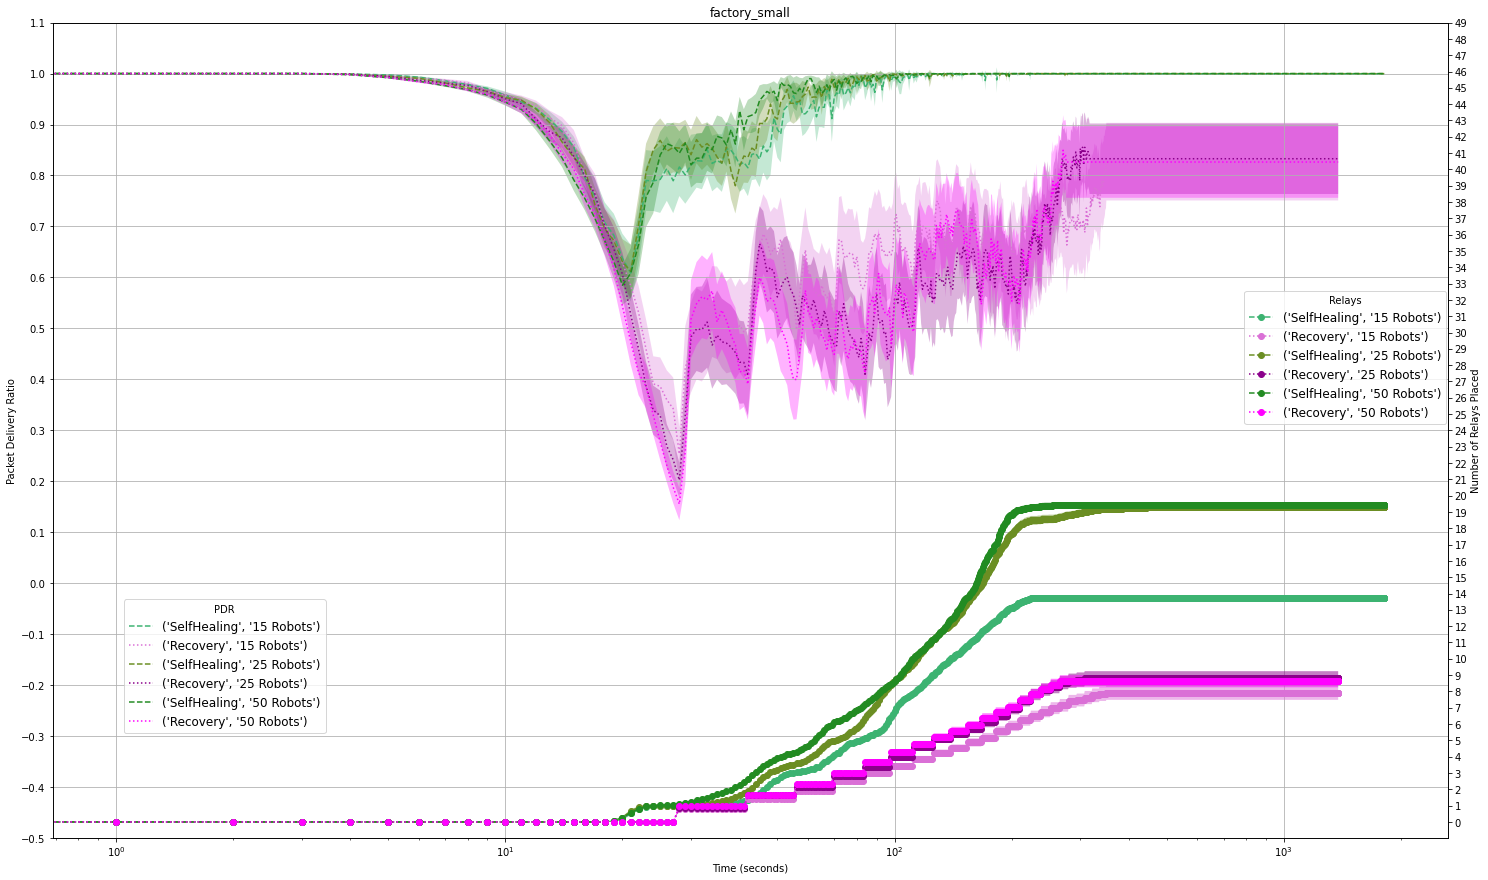

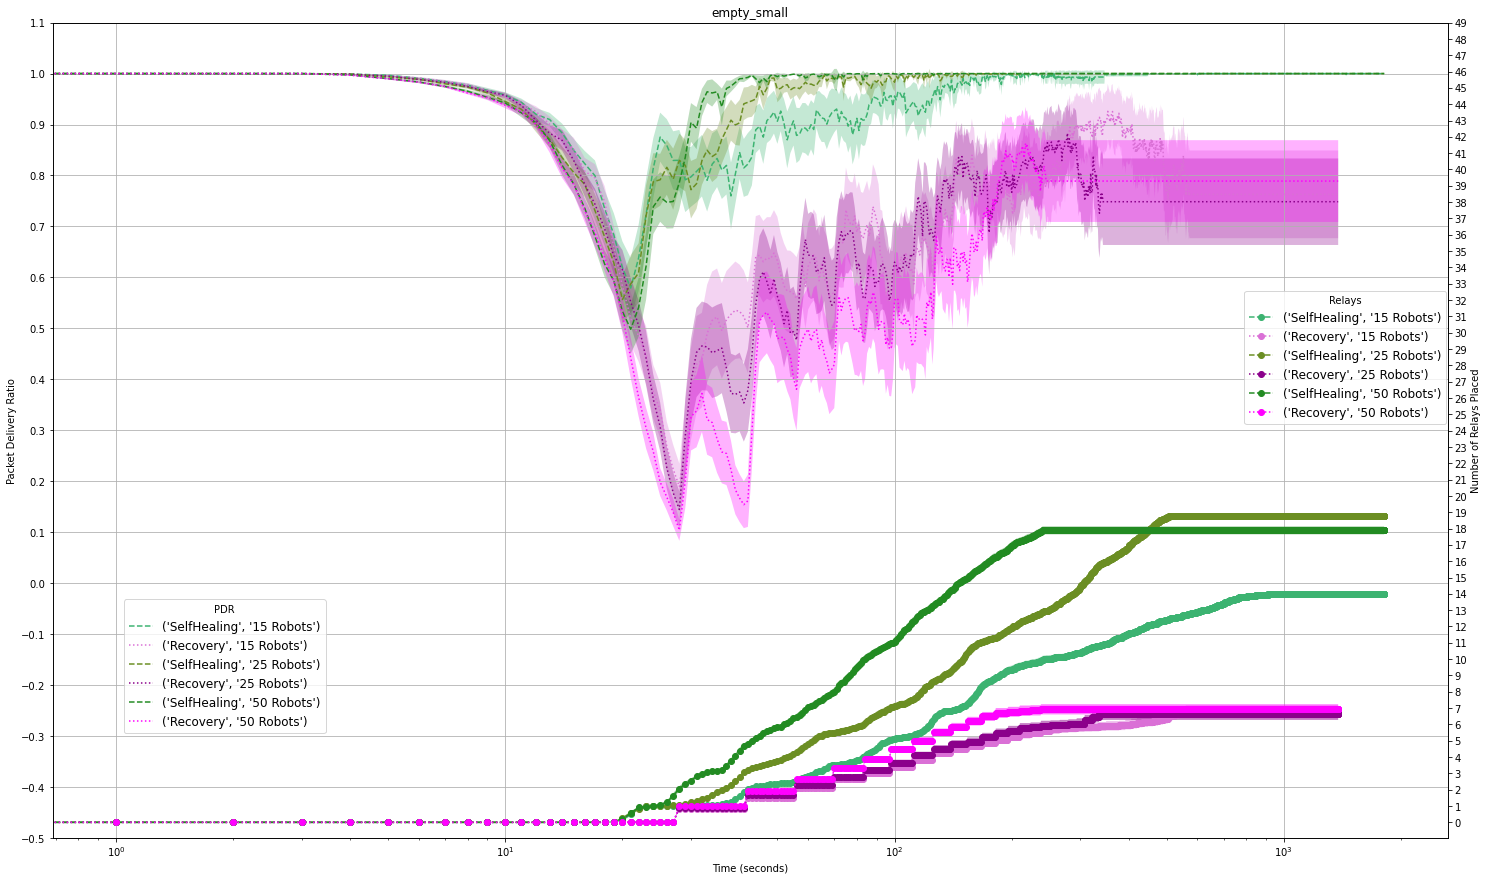

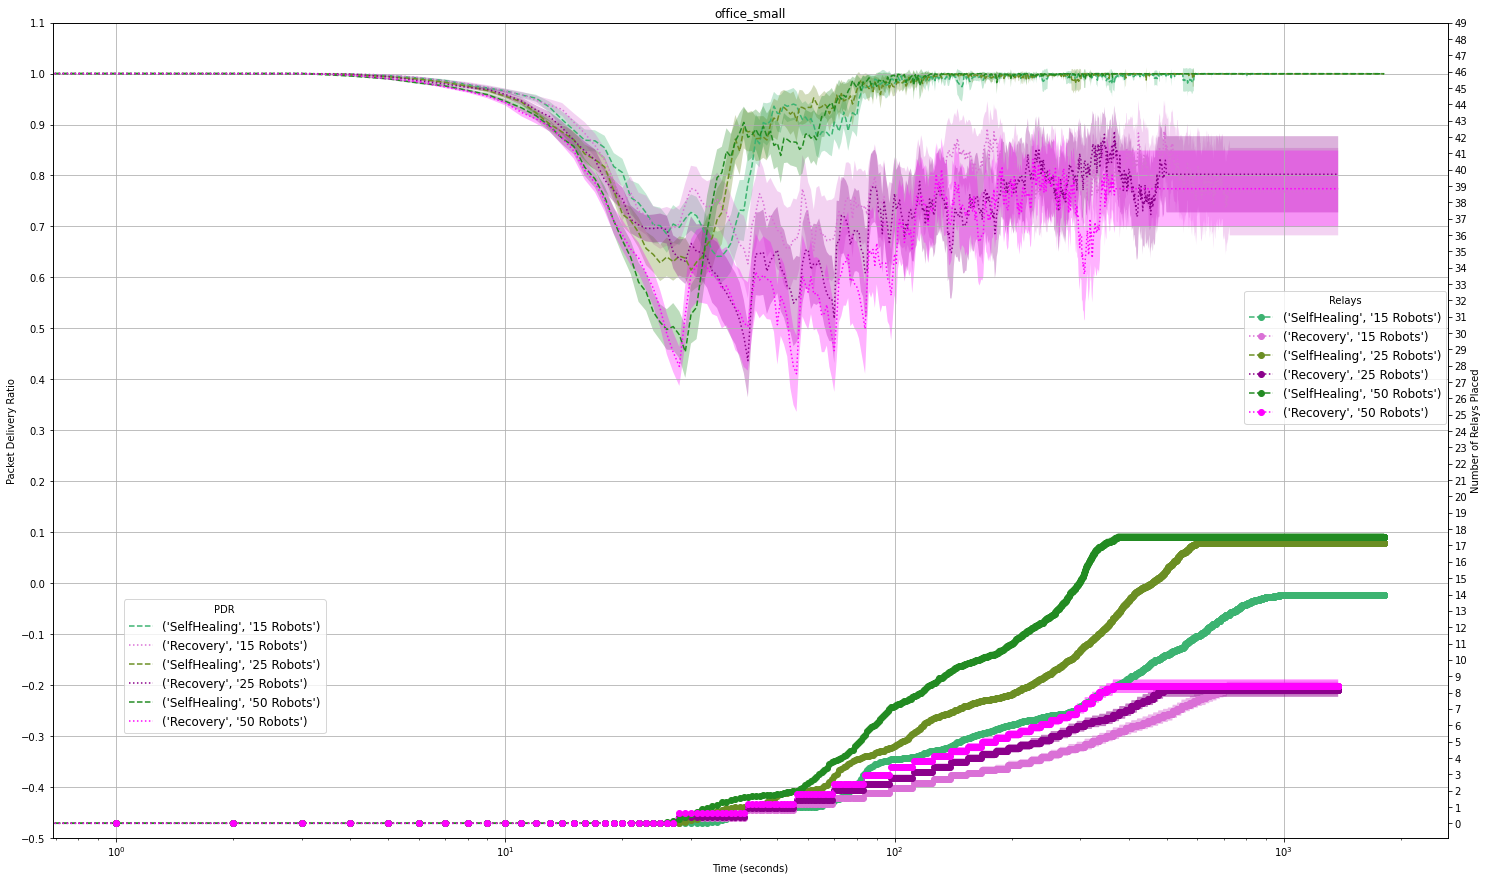

In [114]:
#============ Plot minimum PDR as Relays are placed with time
import math

plt.rcParams['pdf.fonttype']   = 42
plt.rcParams['ps.fonttype']    = 42
plt.rcParams['figure.figsize'] = [25, 15]

# format -> data = {seed1: {config: {....}}, PDRs: [[1,1,1,1], [1,1,1,1], ...], numOfRelays: [0, 1,2, ..]},
#                   seed2: {...} , ...}
data      =  []
for file in LOGFILES:
  FILENAME = file
  # gather
  with open(FILENAME,'r') as f:
    lines       = [json.loads(l) for l in f]
    PDRs        = []
    numOfRelays = []
    time        = []
    for line in lines:
        if line["type"] == "simSetting":
            numRobots       = line['simSetting']['numRobots'] 
            floorplan       = line['simSetting']['floorplan'] 
            relayAlgorithm  = line['simSetting']['relayAlgorithm']
            seed            = line['simSetting']['seed']
            
        
        if ((line["type"] == "KPI") and ('PDRs' in line.keys())):
            PDRs         += [min(line['PDRs'])]
            numOfRelays  += [line['numOfRelays']]
            time         += [line['time']]

    data += [
        {"numRobots":       numRobots,
         "floorplan":       floorplan,
         "relayAlgorithm":  relayAlgorithm,
         "PDRs":            PDRs,
         "numOfRelays":     numOfRelays,
         "time":            time,
         "seed":            seed
        }
    ]

for d in data :
    if d["numOfRelays"][-1] == 0:
        print(d['seed'])
        
floorplans      = list(set([d['floorplan'] for d in data]))
relayAlgorithms = list(set([d['relayAlgorithm'] for d in data]))
numRobots       = list(set([d['numRobots'] for d in data]))
numRobots.sort()

for floorplan in floorplans:
    (fig,ax)   = plt.subplots()
    ax2        = ax.twinx()
    lines      = {}
    linesfill  = {}
    rlines     = {}
    rlinesfill = {}
    for value in numRobots:
        toPlot = {}
        
        for relayAlgorithm in relayAlgorithms:
            toPlot[value] = {"mean": [], "yerr": [], "y1err": [], "y2err": [], "rmean": [], "ryerr": [], "ry1err": [], "ry2err": []}
            timelines       = [d['time'] for d in data if d['relayAlgorithm']==relayAlgorithm]        
            maxtime         = max([t[-1] for t in timelines])
            for i in range(int(maxtime)):
                try:
                    (pm, ph) = mean_confidence_interval(
                        [
                         d["PDRs"][i] for d in data            if 
                         d['numRobots']      == value          and 
                         d['floorplan']      == floorplan      and 
                         d['relayAlgorithm'] == relayAlgorithm
                        ]
                    )

                    (rm, rh) = mean_confidence_interval(
                        [
                         d["numOfRelays"][i] for d in data     if      
                         d['numRobots']      == value          and 
                         d['floorplan']      == floorplan      and 
                         d['relayAlgorithm'] == relayAlgorithm
                        ]
                    )

                except:
                    pass
                
                # for PDR
                toPlot[value]["mean"]    += [pm]
                toPlot[value]["yerr"]    += [ph]
                toPlot[value]["y1err"]   += [pm-ph]
                toPlot[value]["y2err"]   += [pm+ph]
                
                # for relays
                toPlot[value]["rmean"]    += [rm]
                toPlot[value]["ryerr"]    += [rh]
                toPlot[value]["ry1err"]   += [rm-rh]
                toPlot[value]["ry2err"]   += [rm+rh]

            y                             = toPlot[value]["mean"]
            x                             = np.arange(0, len(y))
            yerr                          = toPlot[value]["yerr"]
            lines[(floorplan, value)]     = ax.errorbar(x, y, linestyle=linestyles[relayAlgorithm],color=linecolors[(value, relayAlgorithm)],label=(relayAlgorithm, str(value)+" Robots"))
            linesfill[(floorplan, value)] = ax.fill_between(x, toPlot[value]["y1err"], toPlot[value]["y2err"] ,alpha=0.3, facecolor=linecolors[(value, relayAlgorithm)])
            
            ry                             = toPlot[value]["rmean"]
            rx                             = np.arange(0, len(y))          
            ryerr                          = toPlot[value]["ryerr"]
            rlines[(floorplan, value)]     = ax2.errorbar(rx, ry, linestyle=linestyles[relayAlgorithm], marker='o', c=linecolors[(value, relayAlgorithm)],label=(relayAlgorithm, str(value)+" Robots"))
            rlinesfill[(floorplan, value)] = ax2.fill_between(x, toPlot[value]["ry1err"], toPlot[value]["ry2err"] ,alpha=0.5, facecolor=linecolors[(value, relayAlgorithm)])
    
    #convert x-axis to Logarithmic scale
    ax.grid(True)
    plt.title(floorplan)
    plt.xscale("log")
    ax.set_xlabel("Time (seconds)")
    ax.set_yticks(np.arange(-0.5, 1.2, 0.1))
    ax2.yaxis.set_ticks(np.arange(0, 50))
    ax.set_ylabel("Packet Delivery Ratio")
    ax2.set_ylabel('Number of Relays Placed')
    ax.legend(bbox_to_anchor=(0.2, 0.3), title="PDR",fontsize='large', fancybox=True)
    ax2.legend(bbox_to_anchor=(0.85, 0.5), title="Relays", fontsize='large', fancybox=True)
    ralllines     = rlines
    ralllinesfill = rlinesfill
    plt.show()

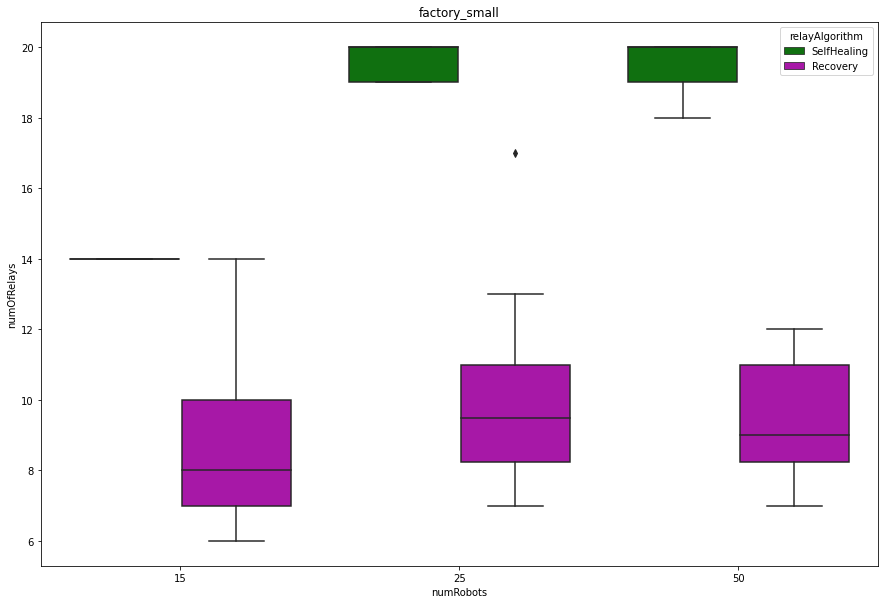

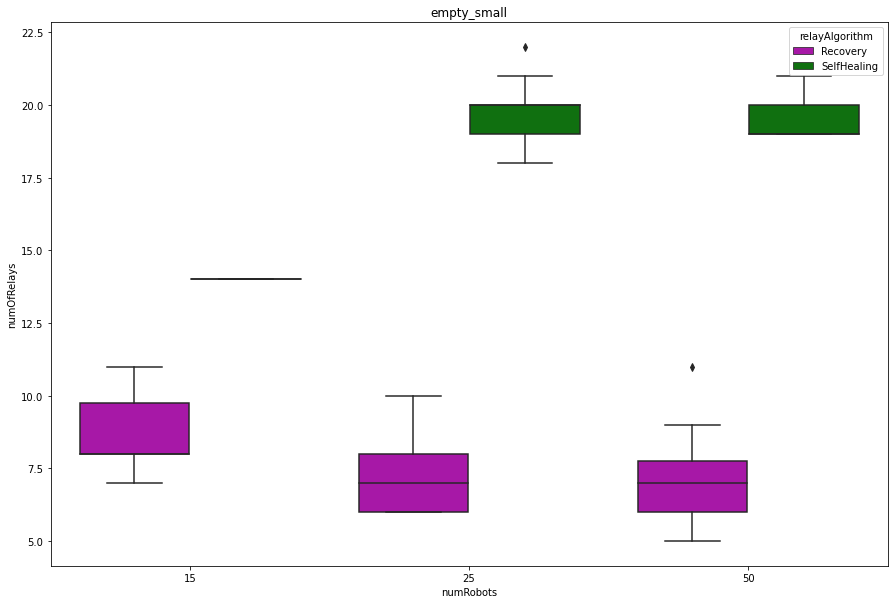

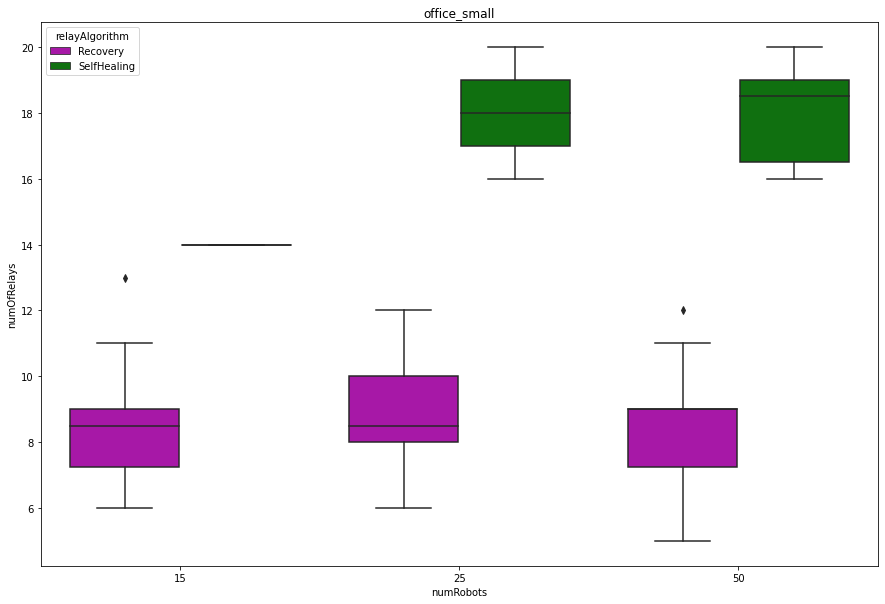

In [100]:
#============ Relays
plt.rcParams['pdf.fonttype']   = 42
plt.rcParams['ps.fonttype']    = 42
plt.rcParams['figure.figsize'] = [15, 10]

# format -> data = {seed1: {config: {....}}, timeToCompletion: 2142}, seed2: {...} , ...}
data      =  []
for file in LOGFILES:
  FILENAME = file
  # gather
  with open(FILENAME,'r') as f:
    lines  = [json.loads(l) for l in f]
    for line in lines:
        if line["type"] == "simSetting":
            numRobots             = line['simSetting']['numRobots'] 
            floorplan             = line['simSetting']['floorplan'] 
            relayAlgorithm        = line['simSetting']['relayAlgorithm']
            
        
        if ((line["type"] == "KPI") and ('PDRs' in line.keys())) :
            numOfRelays  += [line['numOfRelays']]
 
    data += [
        {"numRobots":       numRobots,
         "floorplan":       floorplan,
         "relayAlgorithm":  relayAlgorithm,
         "numOfRelays":     numOfRelays[-1],
        }
    ]

floorplans      = list(set([d['floorplan'] for d in data]))
relayAlgorithms = list(set([d['relayAlgorithm'] for d in data]))
numRobots       = list(set([d['numRobots'] for d in data]))
numRobots.sort()
my_palette      = {"Recovery": "m", "SelfHealing": "g"} 

for floorplan in floorplans:
    (fig,ax) = plt.subplots()
    
    df  = pd.DataFrame([d for d in data if d['floorplan'] == floorplan])

    sns.boxplot(
        x="numRobots", y="numOfRelays", hue ="relayAlgorithm", palette=my_palette, data=df
    ).set_title(floorplan)
